In [1]:
run main.py

Problem name: Optimize EMG signal processing parameters to cross-corelate with grip force
	C++ class name: pybind11::object

	Global dimension:			251
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [2, 2, 2, 2, 2, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Sampling rate: 992.969696969697 Hz
	FFT window size: 496 samples
	FFT resolution: 2.0019550342130987 Hz



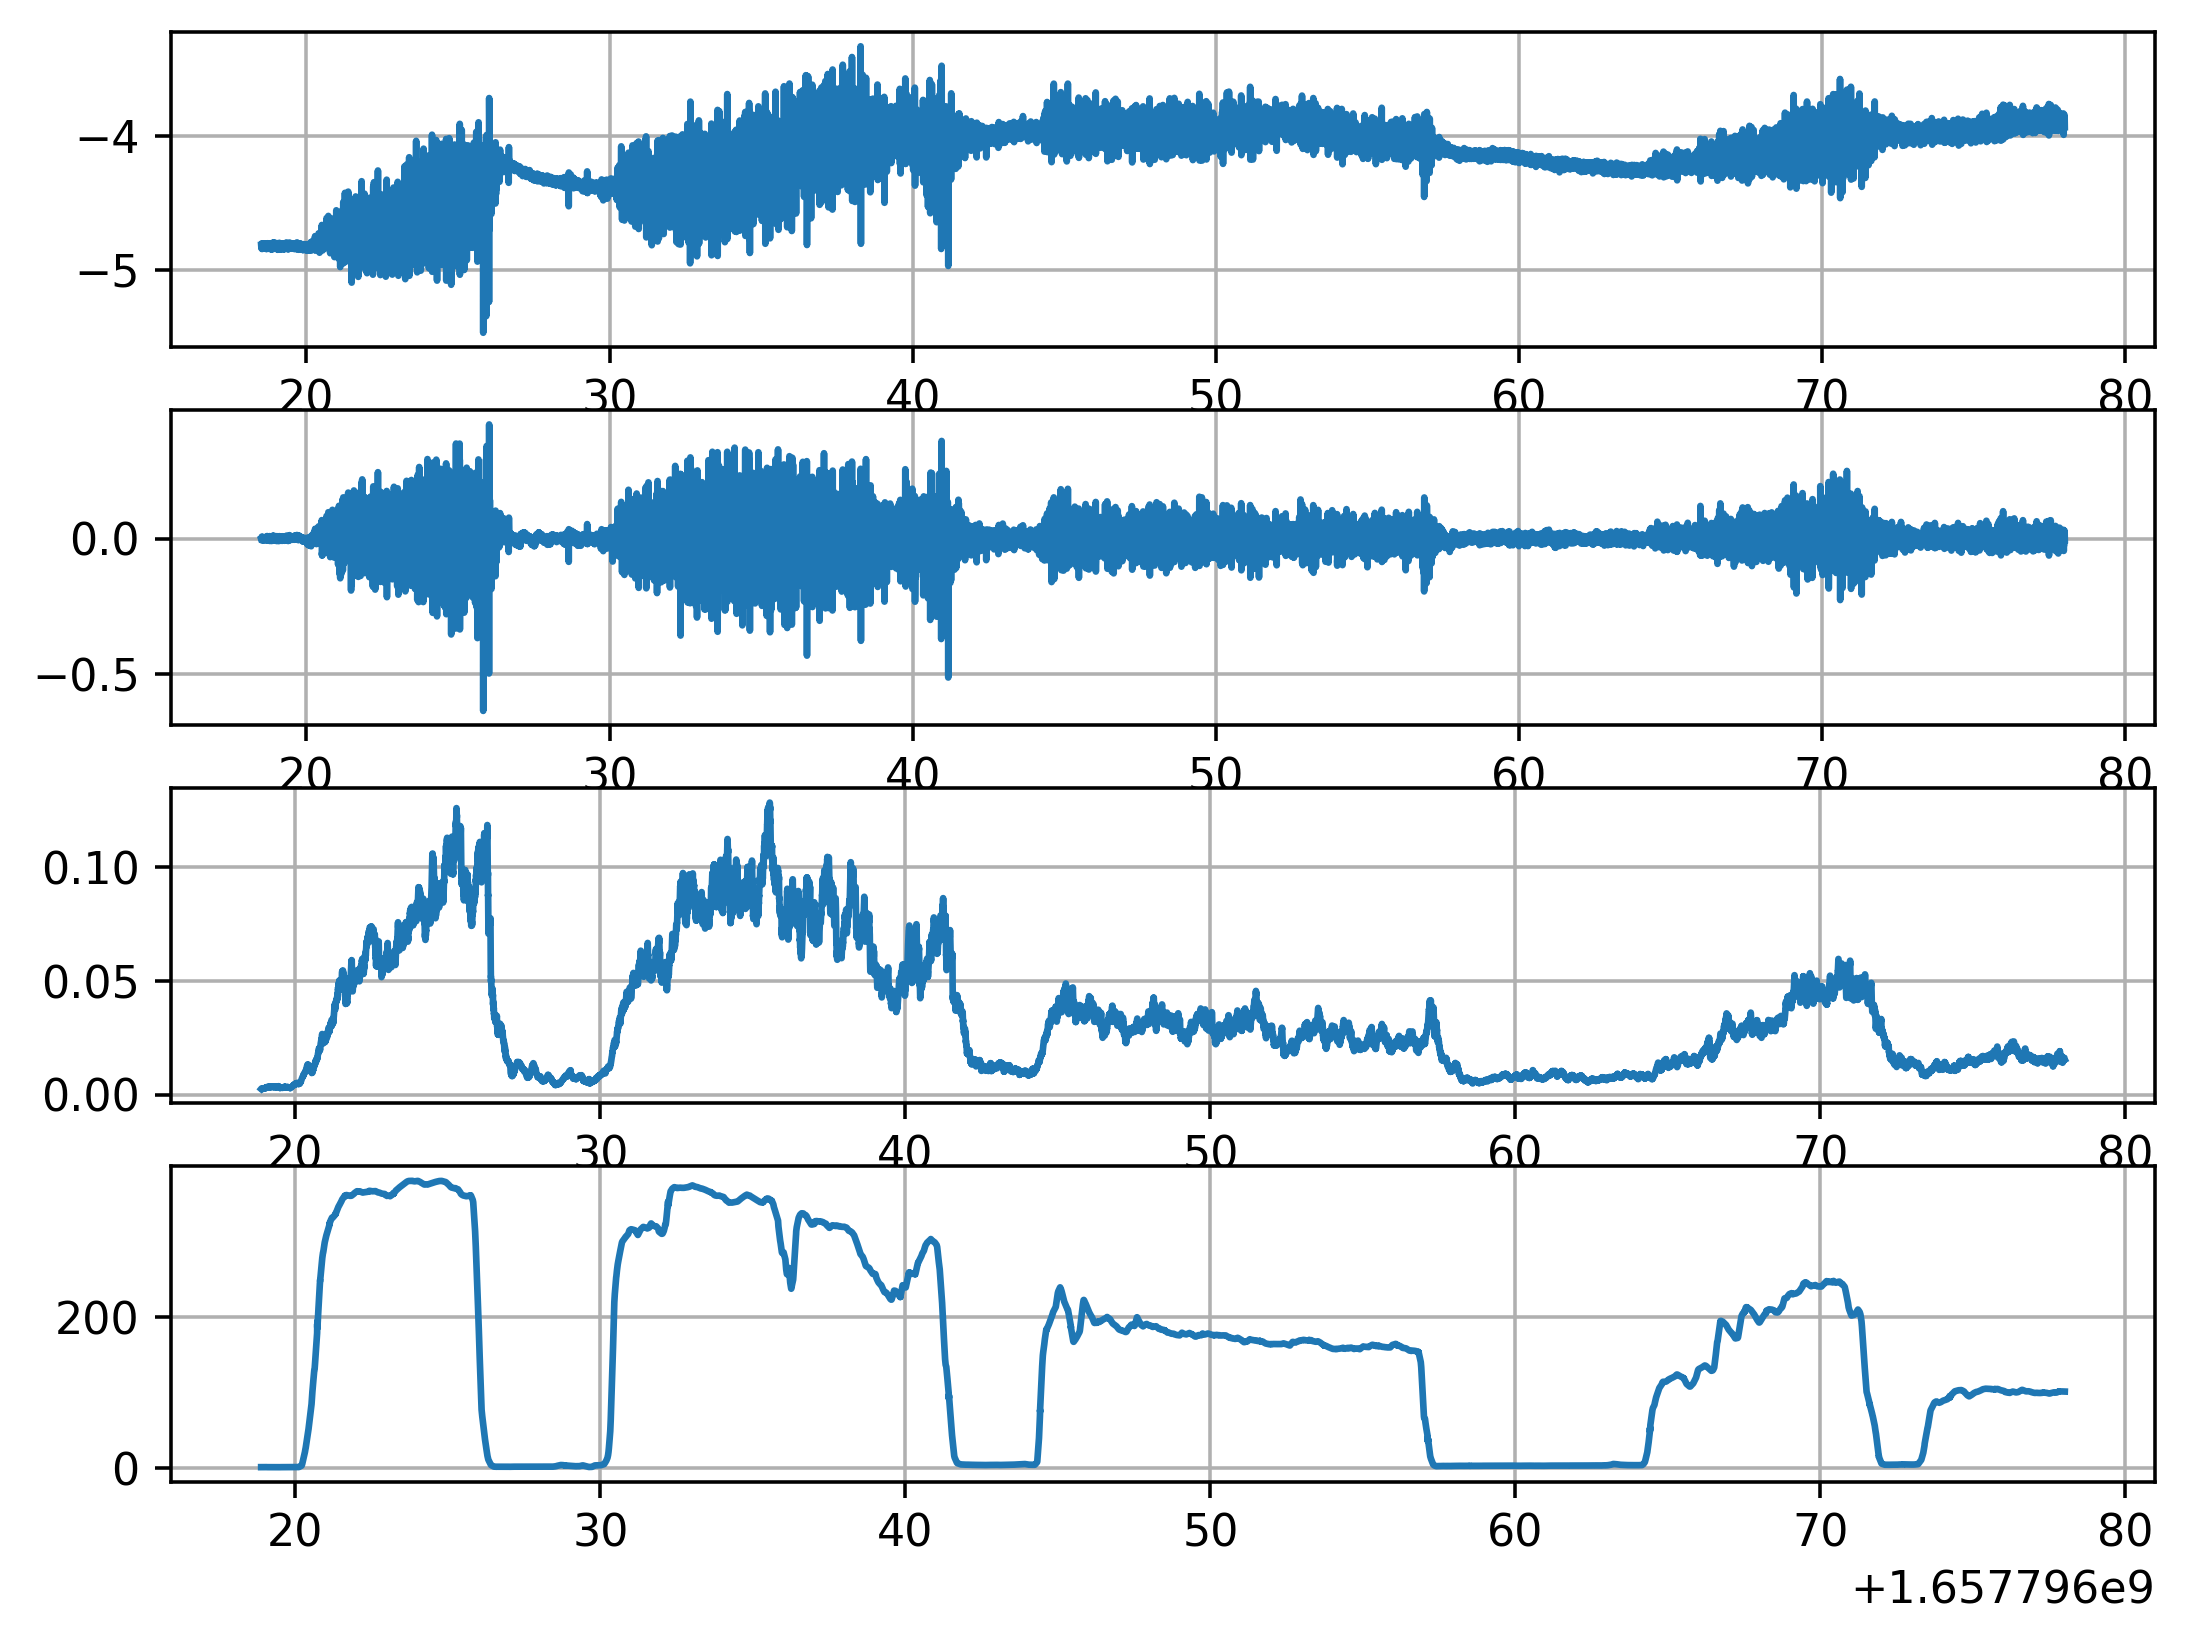

In [36]:
import scipy.fft
import numpy as np
import scipy.signal
import random
import matplotlib.pyplot as plt

# Attenuation/amplification of single frequencies
x = np.random.random(249)
# EMA relative window size
x = np.append(x, random.random()*0.5)
# EMA smoothing factor
x = np.append(x, random.random()*0.05)
# DC offset always removed
x[0] = 0
emg_dat = prob_var.emg_dat
grip_dat = prob_var.grip_dat
time_dat = prob_var.time_dat
emg_fft = prob_var.emg_fft
fft_dim = prob_var.fft_dim
fft_window_size = prob_var.window_size
sampling_rate = prob_var.sampling_rate
emg_ifft = scipy.fft.irfft(emg_fft * x[:fft_dim])
rolling_window_size = round(x[fft_dim] * sampling_rate)
if rolling_window_size > fft_window_size:
  rolling_window_size  = fft_window_size

emg_abs = np.abs(emg_ifft.ravel()) 
window_ema = np.array([(1-x[fft_dim+1])**i for i in range(rolling_window_size)]) 
window_ema = window_ema / window_ema.sum() 
emg_ema = scipy.signal.fftconvolve(emg_abs, window_ema[::-1], mode='valid')

plt.figure(figsize=(8, 6), dpi=320)
plt.subplot(4, 1, 1)
plt.plot(time_dat.ravel(), emg_dat.ravel())
plt.grid(which='both')
plt.subplot(4, 1, 2)
plt.plot(time_dat.ravel(), emg_ifft.ravel())
plt.grid(which='both')
plt.subplot(4, 1, 3)
plt.plot(time_dat.ravel()[rolling_window_size-1:], emg_ema)
plt.grid(which='both')
plt.subplot(4, 1, 4)
plt.plot(time_dat.ravel()[rolling_window_size-1:], grip_dat.ravel()[rolling_window_size-1:])
plt.grid(which='both')
plt.show()

Cross-correlation with Pearson r

EMA - GRIP:
0.8950371994123173
RMS - GRIP:
0.8879507550507612
RMS - EMA:
0.9939743988835484
EMA -> Corr at 0 lag: [0.8950372]
RMS -> Corr at 0 lag: [0.88795076]
EMA -> Max corr: 0.909725360452663, Lag: 191 or 0.192352294921875 sec
RMS -> Max corr: 0.908952951968061, Lag: 213 or 0.214508056640625 sec


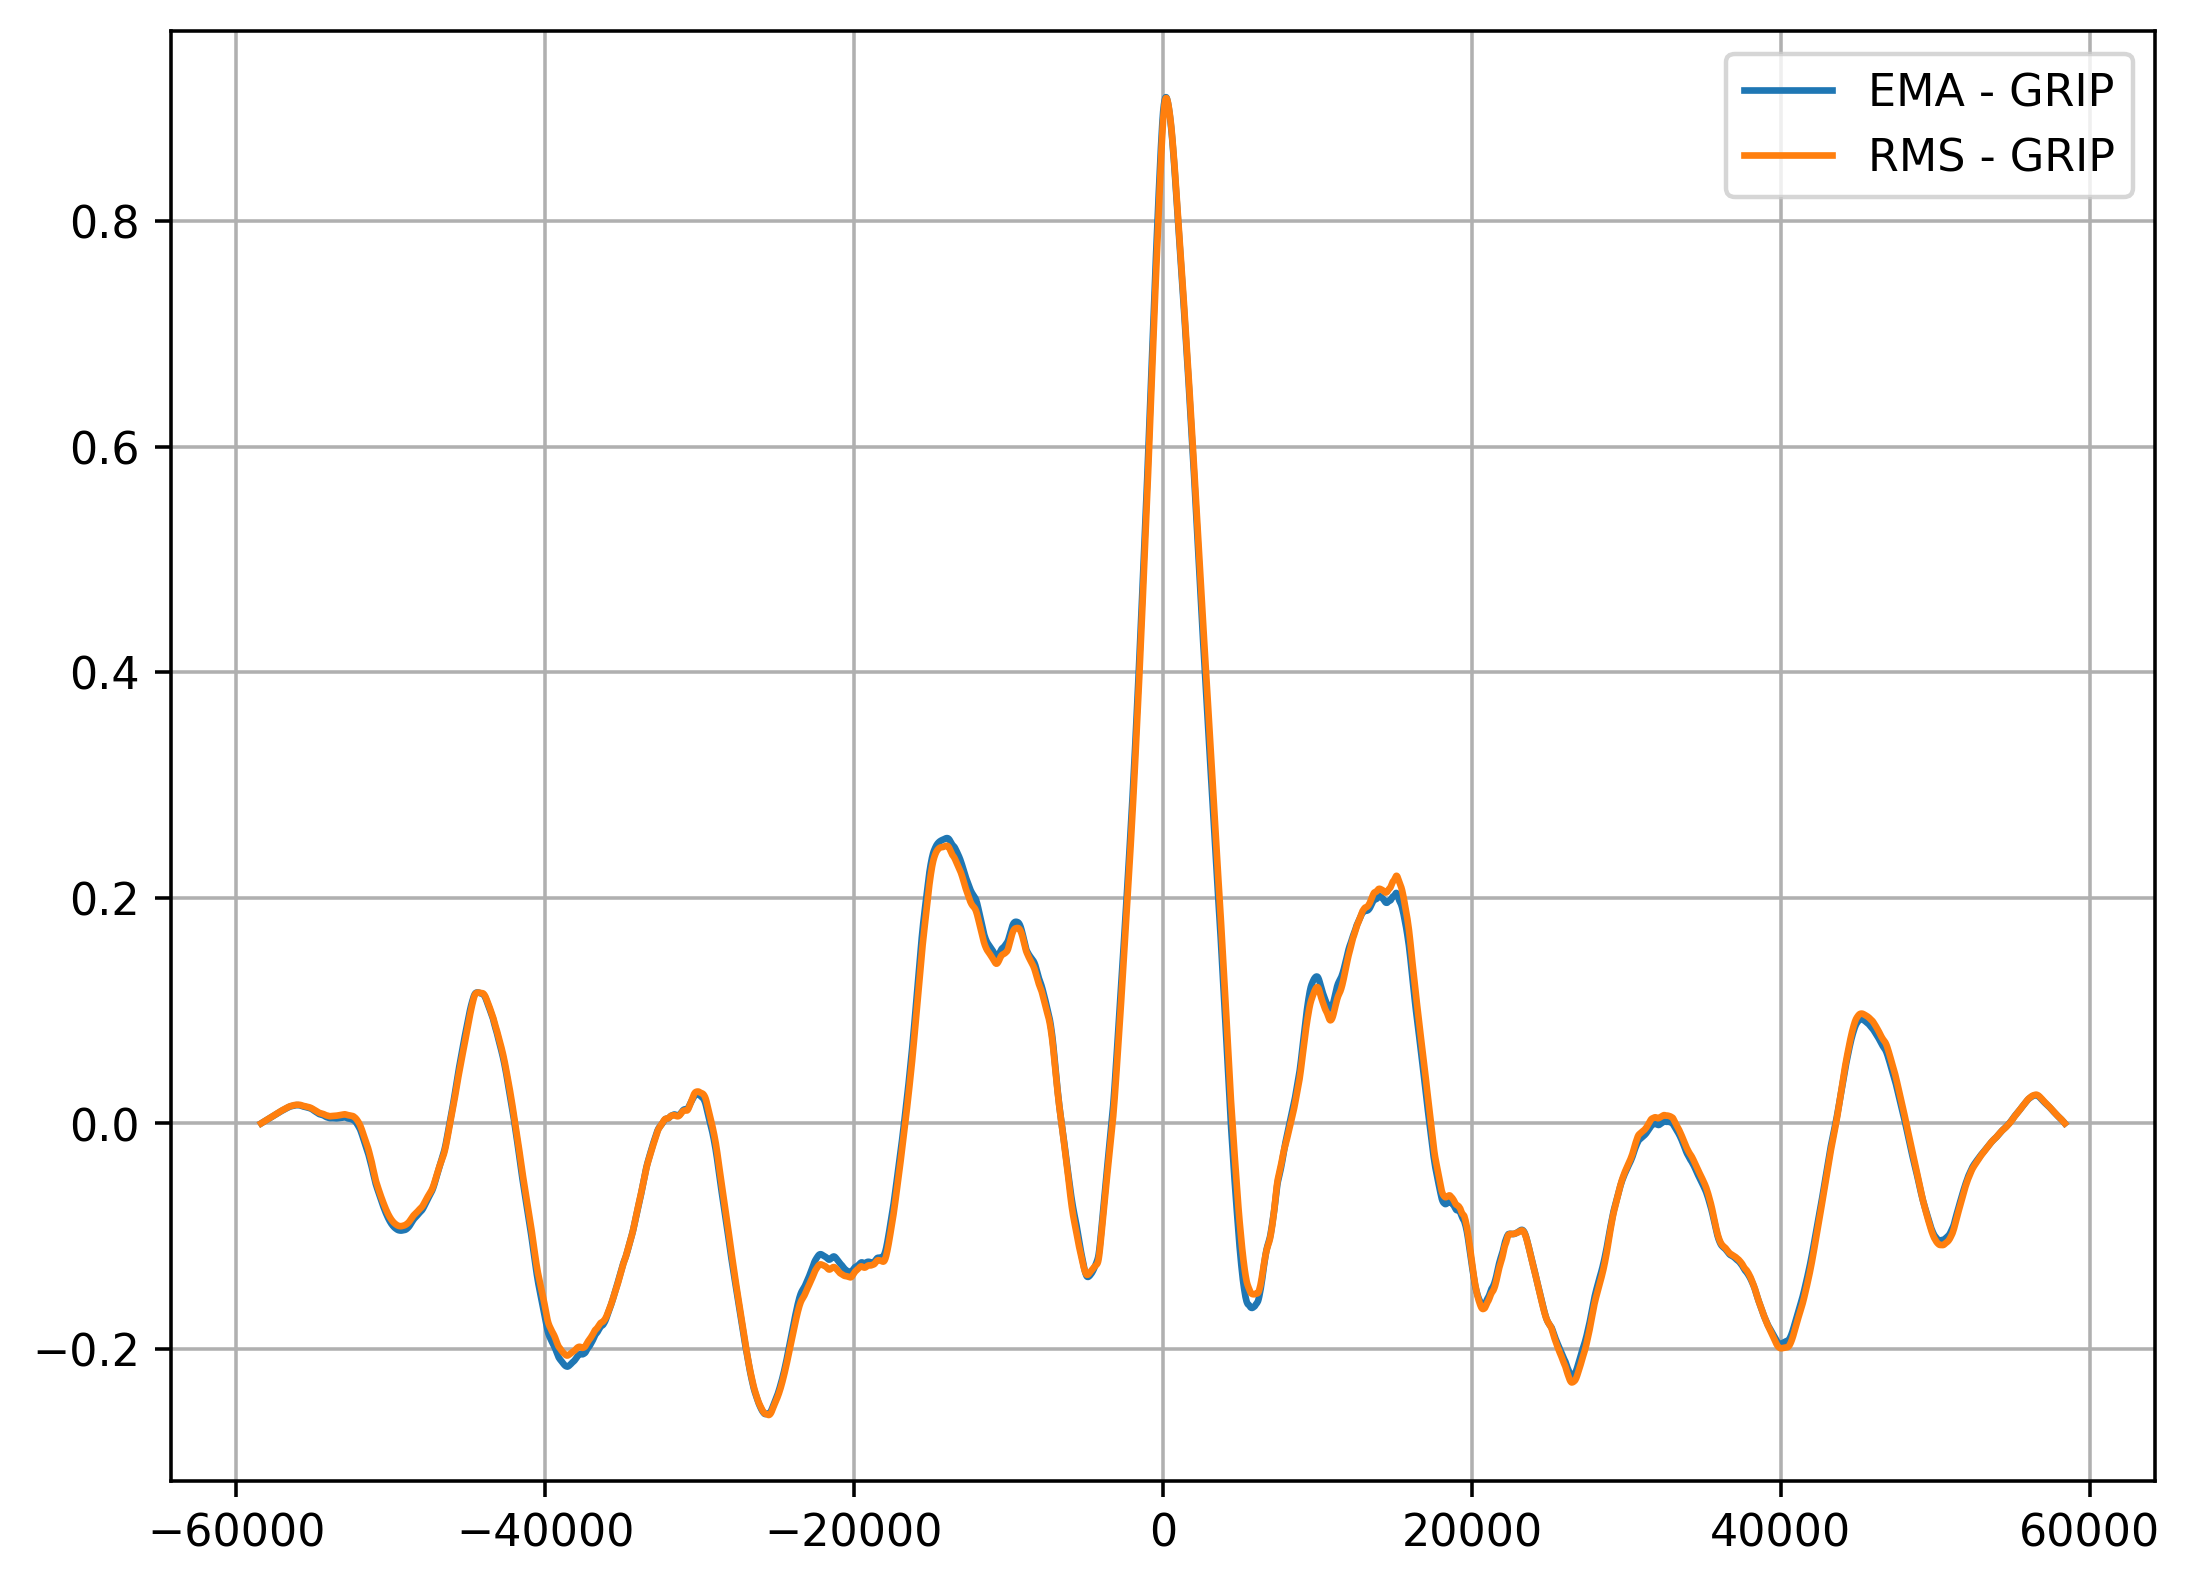

In [216]:
import scipy.signal
import scipy.stats
import numpy as np
# Flatten signals after windowed smoothing
ema = emg_ema.flatten()
rms = emg_rms.flatten()
grip = prob_var.grip_dat.flatten()[window_size-1:]
# Demean signals for 
ema = ema - ema.mean()
rms = rms - rms.mean()
grip = grip - grip.mean()

# corr_ema = scipy.signal.correlate(ema - np.mean(ema), grip - np.mean(grip), method='fft', mode='full')
corr_ema = scipy.signal.correlate(ema, grip, method='fft', mode='full')
corr_ema = np.convolve(ema, grip[::-1])
corr_ema /= (len(grip) * ema.std() * grip.std())
# corr_rms = scipy.signal.correlate(rms - np.mean(rms), grip - np.mean(grip), method='fft', mode='full')
corr_rms = scipy.signal.correlate(rms, grip, method='fft', mode='full')
corr_rms /= (len(grip) * rms.std() * grip.std())
lags = scipy.signal.correlation_lags(len(ema), len(grip), mode='full')
# corr = scipy.signal.fftconvolve(emg_ema.flatten(), emg_rms.flatten()[::-1], mode='full')
# corr = scipy.signal.fftconvolve(emg_ema.flatten(), prob_var.grip_dat.flatten()[-window_size::-1] / np.sum(prob_var.grip_dat.flatten()[-window_size::-1] / 10), mode='full')
print(f'EMA - GRIP:')
print(scipy.stats.pearsonr(ema - np.mean(ema), grip - np.mean(grip))[0])
print(f'RMS - GRIP:')
print(scipy.stats.pearsonr(rms - np.mean(rms), grip - np.mean(grip))[0])
print(f'RMS - EMA:')
print(scipy.stats.pearsonr(rms - np.mean(rms), ema - np.mean(ema))[0])
max_corr_lag_ema = lags[np.argmax(np.abs(corr_ema))]
max_corr_lag_rms = lags[np.argmax(np.abs(corr_rms))]
print(f'EMA -> Corr at 0 lag: {corr_ema[lags == 0]}')
print(f'RMS -> Corr at 0 lag: {corr_rms[lags == 0]}')
print(f'EMA -> Max corr: {np.abs(corr_ema).max()}, Lag: {max_corr_lag_ema} or {max_corr_lag_ema/prob_var.sampling_rate} sec')
print(f'RMS -> Max corr: {np.abs(corr_rms).max()}, Lag: {max_corr_lag_rms} or {max_corr_lag_rms/prob_var.sampling_rate} sec')
plt.figure(figsize=(8, 6), dpi=320)
plt.plot(lags, corr_ema)
plt.plot(lags, corr_rms)
plt.legend(['EMA - GRIP', 'RMS - GRIP'])
plt.grid(which='both')
plt.show()

In [261]:
%timeit corr_ema = scipy.signal.correlate(ema, grip, method='fft', mode='full')
%timeit corr_ema = scipy.signal.fftconvolve(ema, grip[::-1], mode='full')
%timeit corr_ema = np.convolve(ema, grip[::-1])
%timeit corr_ema = np.correlate(ema, grip, mode='full')

5.37 ms ± 476 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.25 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
462 ms ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
359 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [93]:
import numba as nb
def rolling_window(emg_arr, window_size):
  shape = emg_arr.shape[:-1] + (emg_arr.shape[-1] - window_size + 1, window_size)
  strides = emg_arr.strides + (emg_arr.strides[-1],)
  return np.lib.stride_tricks.as_strided(emg_arr, shape=shape, strides=strides)


@nb.jit(nb.float64[:,:](nb.float64[:], nb.int64), nopython=True)
def rolling_window_nb(emg_arr, window_size):
  shape = emg_arr.shape[:-1] + (emg_arr.shape[-1] - window_size + 1, window_size)
  strides = emg_arr.strides + (emg_arr.strides[-1],)
  return np.lib.stride_tricks.as_strided(emg_arr, shape=shape, strides=strides)

In [101]:
%timeit rolling_window_nb(grip, 500)
%timeit rolling_window(grip, 500)

593 ns ± 21.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
3.54 µs ± 49.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [248]:
def exponential_ma(emg_rolling, decay, window_size):
  # ema_decay = 0.005
  window_ema = np.array([(1-decay)**i for i in range(window_size)])
  window_ema = window_ema / window_ema.sum()
  emg_abs = np.abs(emg_rolling)
  return scipy.signal.fftconvolve(emg_abs, window_ema[::-1], mode='valid')
  return np.average(np.abs(emg_rolling), axis=-1, weights=window_ema)

@nb.jit(nb.float64[:](nb.float64[:,:], nb.float64, nb.int64), nopython=True, fastmath=True)
def exponential_ma_nb(emg_rolling, decay, window_size):
  # ema_decay = 0.005
  window_ema = np.array([(1-decay)**i for i in range(window_size)])
  window_ema = window_ema / np.sum(window_ema)
  emg_abs = np.abs(emg_rolling)
  emg_ema = np.sum(emg_abs*window_ema, axis=-1)
  return emg_ema

In [247]:
%timeit exponential_ma(b.ravel(), 0.005, window_size)
%timeit exponential_ma_nb(windowed_emg, 0.005, window_size)

1.98 ms ± 83.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
124 ms ± 4.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [220]:
exponential_ma_nb(windowed_emg, 0.005, window_size)
# scipy.signal.fftconvolve(np.abs(b.flat), window_ma[::-1], mode='valid')
# b
# windowed_emg

array([0.00961997, 0.0096533 , 0.00968365, ..., 0.02534467, 0.02565753,
       0.02583124])

In [244]:
np.all(np.isclose(
  exponential_ma(b.flat, 0.005, window_size),
  exponential_ma_nb(windowed_emg, 0.005, window_size)
  ))
# np.all(np.isclose(
#   exponential_ma(b.flat, 0.005, window_size), 
#   scipy.signal.fftconvolve(np.abs(b.flat), window_ma[::-1], mode='valid'),
#   ))

True